In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [2]:
# Libraries
# ==============================================================================
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.model_selection_statsmodels import backtesting_sarimax
from skforecast.model_selection_statsmodels import grid_search_sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

%config Completer.use_jedi = False


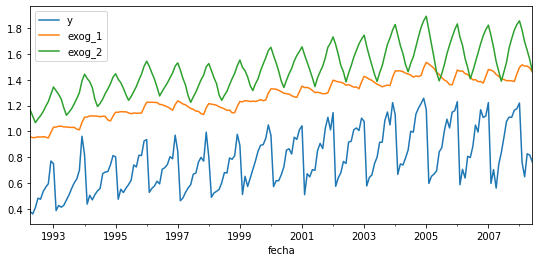

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Sarimax without exogenous variables

In [4]:
# Train Sarimax and predict
# ==============================================================================
model = SARIMAX(
            endog = data.y,
        ).fit()

pred = model.get_forecast(steps=1)
pd.concat((pred.predicted_mean, pred.conf_int(alpha=0.05)), axis=1)

0   lower y   upper y
2008-07-01  0.746465  0.439749  1.053181

In [5]:
# Backtest Sarimax without refit
# ==============================================================================
steps = 65
n_backtest = 65 * 2 + 1
metric, predictions_backtest = backtesting_sarimax(
                                    y          = data.y,
                                    order      = (1, 0, 0),
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training: 64
Number of observations used for backtesting: 131
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 1 observations.
Error de backtest: [0.24797998]


predicted_mean   lower y   upper y
1997-08-01        0.654795  0.408919  0.900671
1997-09-01        0.640432  0.296503  0.984361
1997-10-01        0.626384  0.209719  1.043049
1997-11-01        0.612644  0.136690  1.088598
1997-12-01        0.599205  0.072747  1.125664
...                    ...       ...       ...
2008-02-01        0.278790 -0.863255  1.420834
2008-03-01        0.272675 -0.871060  1.416409
2008-04-01        0.266693 -0.878656  1.412043
2008-05-01        0.260843 -0.886049  1.407735
2008-06-01        0.798350  0.552474  1.044227

[131 rows x 3 columns]

In [6]:
# Comprobación manual
# ==============================================================================
steps = 65
n_backtest = 65 * 2 + 1
initial_train_size = len(data) - n_backtest

model = SARIMAX(
            endog = data['y'].iloc[:initial_train_size + 0 * steps],
            order = (1, 0, 0)
        ).fit()
pred = model.get_forecast(steps=steps)
pred_1 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

last_window_end   = initial_train_size + 1 * steps
last_window_start = (initial_train_size + 1 * steps) - steps 
last_window_y     = data['y'].iloc[last_window_start:last_window_end]
model = model.extend(endog=last_window_y)
pred = model.get_forecast(steps=steps)
pred_2 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

last_window_end   = initial_train_size + 2 * steps
last_window_start = (initial_train_size + 2 * steps) - steps 
last_window_y     = data['y'].iloc[last_window_start:last_window_end]
model = model.extend(endog=last_window_y)
pred  = model.get_forecast(steps=1)
pred_3 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

np.allclose(
    predictions_backtest,
    pd.concat([pred_1, pred_2, pred_3])
)

True

In [7]:
# Grid search hiperparameters without refit
# ==============================================================================
param_grid = {'order': [(1, 0, 0), (5, 0, 0), (10, 0, 0)]}

results = grid_search_sarimax(
            y       = data.y,
            param_grid = param_grid,
            initial_train_size = len(data) - n_backtest,
            steps   = steps,
            metric  = 'mean_absolute_error',
            refit   = False,
            verbose = False,
            fit_kwargs = {'maxiter': 200, 'disp': 0}
         )

# Results grid search
# ==============================================================================
results.head(3)

2021-11-07 21:41:29,658 root       INFO  Number of models compared: 3
 67%|██████████████████████████████               | 2/3 [00:00<00:00, 10.34it/s]/home/ximo/anaconda3/envs/cienciadedatos/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


params                 metric  \
2  {'order': (10, 0, 0), 'seasonal_order': (0, 0,...  [0.17569342437597185]   
1  {'order': (5, 0, 0), 'seasonal_order': (0, 0, ...  [0.31220420807271043]   
0  {'order': (1, 0, 0), 'seasonal_order': (0, 0, ...   [0.4255719417717085]   

        order seasonal_order trend  
2  (10, 0, 0)   (0, 0, 0, 0)  None  
1   (5, 0, 0)   (0, 0, 0, 0)  None  
0   (1, 0, 0)   (0, 0, 0, 0)  None

In [8]:
# Backtest Sarimax with refit
# ==============================================================================
steps = 65
n_backtest = 65 * 2 + 1
metric, predictions_backtest = backtesting_sarimax(
                                    y          = data.y,
                                    order      = (1, 0, 0),
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True,
                                    fit_kwargs = {'maxiter': 500, 'disp': 0}
                               )
print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training: 64
Number of observations used for backtesting: 131
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 1 observations.
Error de backtest: [0.21339966]


predicted_mean   lower y   upper y
1997-08-01        0.654795  0.408919  0.900671
1997-09-01        0.640432  0.296503  0.984361
1997-10-01        0.626384  0.209719  1.043049
1997-11-01        0.612644  0.136690  1.088598
1997-12-01        0.599205  0.072747  1.125664
...                    ...       ...       ...
2008-02-01        0.393111 -1.004913  1.791136
2008-03-01        0.386625 -1.014726  1.787976
2008-04-01        0.380246 -1.024315  1.784807
2008-05-01        0.373972 -1.033686  1.781631
2008-06-01        0.799614  0.492160  1.107068

[131 rows x 3 columns]

In [9]:
# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest

train_size = initial_train_size + 0 * steps
model = SARIMAX(
            endog = data['y'].iloc[:train_size],
            order = (1, 0, 0)
        ).fit()
pred = model.get_forecast(steps=steps)
pred_1 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

train_size = initial_train_size + 1 * steps
model = SARIMAX(
            endog = data['y'].iloc[:train_size],
            order = (1, 0, 0)
        ).fit()
pred = model.get_forecast(steps=steps)
pred_2 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

train_size = initial_train_size + 2 * steps
model = SARIMAX(
            endog = data['y'].iloc[:train_size],
            order = (1, 0, 0)
        ).fit()
pred = model.get_forecast(steps=1)
pred_3 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )
np.allclose(
    predictions_backtest,
    pd.concat([pred_1, pred_2, pred_3])
)

True

In [10]:
# Grid search hiperparameters with refit
# ==============================================================================
param_grid = {'order': [(1, 0, 0), (5, 0, 0), (10, 0, 0)]}

results = grid_search_sarimax(
            y       = data.y,
            param_grid = param_grid,
            initial_train_size = len(data) - n_backtest,
            steps   = steps,
            metric  = 'mean_absolute_error',
            refit   = True,
            verbose = False,
            fit_kwargs = {'maxiter': 500, 'disp': 0}
         )

# Results grid search
# ==============================================================================
results.head(3)

2021-11-07 21:41:31,263 root       INFO  Number of models compared: 3
 67%|██████████████████████████████               | 2/3 [00:00<00:00,  3.57it/s]/home/ximo/anaconda3/envs/cienciadedatos/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


params                 metric  \
2  {'order': (10, 0, 0), 'seasonal_order': (0, 0,...  [0.17380696479271954]   
1  {'order': (5, 0, 0), 'seasonal_order': (0, 0, ...  [0.29269454932751887]   
0  {'order': (1, 0, 0), 'seasonal_order': (0, 0, ...    [0.389801038350877]   

        order seasonal_order trend  
2  (10, 0, 0)   (0, 0, 0, 0)  None  
1   (5, 0, 0)   (0, 0, 0, 0)  None  
0   (1, 0, 0)   (0, 0, 0, 0)  None

# Sarimax with one exogenous variables

In [13]:
# Train Sarimax and predict
# ==============================================================================
model = SARIMAX(
            endog = data.y,
            exog = data['exog_1'],
        ).fit()

pred = model.get_forecast(steps=1, exog=data['exog_1'].iloc[0])
pd.concat((pred.predicted_mean, pred.conf_int(alpha=0.05)), axis=1)

0   lower y   upper y
2008-07-01  0.502256  0.224641  0.779871

In [14]:
# Backtest Sarimax without refit
# ==============================================================================
steps = 65
n_backtest = 65 * 2 + 1
metric, predictions_backtest = backtesting_sarimax(
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    order      = (1, 0, 0),
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training: 64
Number of observations used for backtesting: 131
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 1 observations.
Error de backtest: [0.04994405]


predicted_mean   lower y   upper y
1997-08-01        0.656053  0.437214  0.874893
1997-09-01        0.650730  0.393948  0.907512
1997-10-01        0.638779  0.369080  0.908477
1997-11-01        0.633054  0.358646  0.907462
1997-12-01        0.661743  0.385581  0.937904
...                    ...       ...       ...
2008-02-01        0.845421  0.568204  1.122638
2008-03-01        0.840077  0.562860  1.117294
2008-04-01        0.839516  0.562300  1.116733
2008-05-01        0.831826  0.554609  1.109043
2008-06-01        0.804639  0.585799  1.023479

[131 rows x 3 columns]

In [15]:
# Comprobación manual
# ==============================================================================
steps = 65
n_backtest = 65 * 2 + 1
initial_train_size = len(data) - n_backtest

model = SARIMAX(
            endog = data['y'].iloc[:initial_train_size + 0 * steps],
            exog  = data['exog_1'].iloc[:initial_train_size + 0 * steps],
            order = (1, 0, 0)
        ).fit()

last_window_end   = initial_train_size + 0 * steps
last_window_start = (initial_train_size + 0* steps) - steps 
last_window_y     = data['y'].iloc[last_window_start:last_window_end]
last_window_exog  = data['exog_1'].iloc[last_window_start:last_window_end]
next_window_exog  = data['exog_1'].iloc[last_window_end:last_window_end + steps]
pred = model.get_forecast(steps=steps, exog=next_window_exog)
pred_1 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

last_window_end   = initial_train_size + 1 * steps
last_window_start = (initial_train_size + 1 * steps) - steps 
last_window_y     = data['y'].iloc[last_window_start:last_window_end]
last_window_exog  = data['exog_1'].iloc[last_window_start:last_window_end]
next_window_exog  = data['exog_1'].iloc[last_window_end:last_window_end + steps]
    
model = model.extend(endog=last_window_y, exog=last_window_exog)
pred = model.get_forecast(steps=steps, exog=next_window_exog)
pred_2 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

last_window_end   = initial_train_size + 2 * steps
last_window_start = (initial_train_size + 2* steps) - steps 
last_window_y     = data['y'].iloc[last_window_start:last_window_end]
last_window_exog  = data['exog_1'].iloc[last_window_start:last_window_end]
next_window_exog  = data['exog_1'].iloc[last_window_end:last_window_end + steps]
model = model.extend(endog=last_window_y, exog=last_window_exog)
pred = model.get_forecast(steps=1, exog=next_window_exog)
pred_3 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

np.allclose(
    predictions_backtest,
    pd.concat([pred_1, pred_2, pred_3])
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.27369D-01    |proj g|=  2.66187D-02

At iterate    5    f= -4.27373D-01    |proj g|=  4.47545D-03

At iterate   10    f= -4.27398D-01    |proj g|=  6.08010D-02

At iterate   15    f= -4.27579D-01    |proj g|=  3.52790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     19      1     0     0   1.736D-06  -4.276D-01
  F = -0.42757895383313121     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

True

In [16]:
# Grid search hiperparameters without refit
# ==============================================================================
param_grid = {'order': [(1, 0, 0), (5, 0, 0), (10, 0, 0)]}

results = grid_search_sarimax(
            y       = data.y,
            exog    = data['exog_1'],
            param_grid = param_grid,
            initial_train_size = len(data) - n_backtest,
            steps   = steps,
            metric  = 'mean_absolute_error',
            refit   = False,
            verbose = False,
            fit_kwargs = {'maxiter': 200, 'disp': 0}
         )

# Results grid search
# ==============================================================================
results.head(3)

2021-11-07 21:41:54,173 root       INFO  Number of models compared: 3
100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


params                 metric  \
2  {'order': (10, 0, 0), 'seasonal_order': (0, 0,...  [0.14561210859532775]   
1  {'order': (5, 0, 0), 'seasonal_order': (0, 0, ...  [0.17774372120046317]   
0  {'order': (1, 0, 0), 'seasonal_order': (0, 0, ...  [0.18880239416550276]   

        order seasonal_order trend  
2  (10, 0, 0)   (0, 0, 0, 0)  None  
1   (5, 0, 0)   (0, 0, 0, 0)  None  
0   (1, 0, 0)   (0, 0, 0, 0)  None

In [17]:
# Backtest Sarimax with refit
# ==============================================================================
steps = 65
n_backtest = 65 * 2 + 1
metric, predictions_backtest = backtesting_sarimax(
                                    y          = data.y,
                                    exog       = data['exog_1'],
                                    order      = (1, 0, 0),
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True,
                                    fit_kwargs = {'maxiter': 500, 'disp': 0}
                               )
print(f"Error de backtest: {metric}")
predictions_backtest

/home/ximo/anaconda3/envs/cienciadedatos/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Number of observations used for training: 64
Number of observations used for backtesting: 131
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 1 observations.
Error de backtest: [0.04460486]


predicted_mean   lower y   upper y
1997-08-01        0.656053  0.437214  0.874893
1997-09-01        0.650730  0.393948  0.907512
1997-10-01        0.638779  0.369080  0.908477
1997-11-01        0.633054  0.358646  0.907462
1997-12-01        0.661743  0.385581  0.937904
...                    ...       ...       ...
2008-02-01        0.910476  0.595391  1.225561
2008-03-01        0.904720  0.589635  1.219805
2008-04-01        0.904117  0.589032  1.219202
2008-05-01        0.895835  0.580750  1.210920
2008-06-01        0.833360  0.555207  1.111514

[131 rows x 3 columns]

In [18]:
# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest

train_size = initial_train_size + 0 * steps
next_window_exog  = data['exog_1'].iloc[train_size:train_size + steps]
model = SARIMAX(
            endog = data['y'].iloc[:train_size],
            exog  = data['exog_1'].iloc[:train_size],
            order = (1, 0, 0)
        ).fit()
pred = model.get_forecast(steps=steps, exog=next_window_exog)
pred_1 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

train_size = initial_train_size + 1 * steps
next_window_exog  = data['exog_1'].iloc[train_size:train_size + steps]
model = SARIMAX(
            endog = data['y'].iloc[:train_size],
            exog  = data['exog_1'].iloc[:train_size],
            order = (1, 0, 0)
        ).fit()
pred = model.get_forecast(steps=steps, exog=next_window_exog)
pred_2 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

train_size = initial_train_size + 2 * steps
next_window_exog  = data['exog_1'].iloc[train_size:train_size + 1]
model = SARIMAX(
            endog = data['y'].iloc[:train_size],
            exog  = data['exog_1'].iloc[:train_size],
            order = (1, 0, 0)
        ).fit()
pred = model.get_forecast(steps=1, exog=next_window_exog)
pred_3 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )
np.allclose(
    predictions_backtest,
    pd.concat([pred_1, pred_2, pred_3])
)

/home/ximo/anaconda3/envs/cienciadedatos/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


True

In [19]:
# Grid search hiperparameters with refit
# ==============================================================================
param_grid = {'order': [(1, 0, 0), (5, 0, 0), (10, 0, 0)]}

results = grid_search_sarimax(
            y       = data.y,
            exog       = data['exog_1'],
            param_grid = param_grid,
            initial_train_size = len(data) - n_backtest,
            steps   = steps,
            metric  = 'mean_absolute_error',
            refit   = True,
            verbose = False,
            fit_kwargs = {'maxiter': 500, 'disp': 0}
         )

# Results grid search
# ==============================================================================
results.head(3)

2021-11-07 21:41:56,032 root       INFO  Number of models compared: 3
  0%|                                                     | 0/3 [00:00<?, ?it/s]/home/ximo/anaconda3/envs/cienciadedatos/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.38s/it]


params                 metric  \
2  {'order': (10, 0, 0), 'seasonal_order': (0, 0,...  [0.14699442048580943]   
1  {'order': (5, 0, 0), 'seasonal_order': (0, 0, ...  [0.17362488001977544]   
0  {'order': (1, 0, 0), 'seasonal_order': (0, 0, ...  [0.18355224857263489]   

        order seasonal_order trend  
2  (10, 0, 0)   (0, 0, 0, 0)  None  
1   (5, 0, 0)   (0, 0, 0, 0)  None  
0   (1, 0, 0)   (0, 0, 0, 0)  None

# Sarimax with multiple exogenous variables

In [20]:
# Train Sarimax and predict
# ==============================================================================
model = SARIMAX(
            endog = data.y,
            exog = data[['exog_1', 'exog_2']],
        ).fit()

pred = model.get_forecast(steps=1, exog=data[['exog_1', 'exog_2']].iloc[0,:])
pd.concat((pred.predicted_mean, pred.conf_int(alpha=0.05)), axis=1)

0   lower y  upper y
2008-07-01  0.683546  0.427343  0.93975

In [21]:
# Backtest Sarimax without refit
# ==============================================================================
steps = 65
n_backtest = 65 * 2 + 1
metric, predictions_backtest = backtesting_sarimax(
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    order      = (1, 0, 0),
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = False,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training: 64
Number of observations used for backtesting: 131
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 1 observations.
Error de backtest: [0.04588429]


predicted_mean   lower y   upper y
1997-08-01        0.655524  0.450084  0.860964
1997-09-01        0.667688  0.433793  0.901583
1997-10-01        0.699155  0.457474  0.940837
1997-11-01        0.724326  0.480386  0.968266
1997-12-01        0.751352  0.506747  0.995957
...                    ...       ...       ...
2008-02-01        0.842517  0.597633  1.087401
2008-03-01        0.770082  0.525197  1.014966
2008-04-01        0.714762  0.469878  0.959647
2008-05-01        0.660748  0.415864  0.905632
2008-06-01        0.682714  0.477274  0.888154

[131 rows x 3 columns]

In [22]:
# Comprobación manual
# ==============================================================================
steps = 65
n_backtest = 65 * 2 + 1
initial_train_size = len(data) - n_backtest

model = SARIMAX(
            endog = data['y'].iloc[:initial_train_size + 0 * steps],
            exog  = data[['exog_1', 'exog_2']].iloc[:initial_train_size + 0 * steps],
            order = (1, 0, 0)
        ).fit()

last_window_end   = initial_train_size + 0 * steps
last_window_start = (initial_train_size + 0* steps) - steps 
last_window_y     = data['y'].iloc[last_window_start:last_window_end]
last_window_exog  = data[['exog_1', 'exog_2']].iloc[last_window_start:last_window_end]
next_window_exog  = data[['exog_1', 'exog_2']].iloc[last_window_end:last_window_end + steps]
pred = model.get_forecast(steps=steps, exog=next_window_exog)
pred_1 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

last_window_end   = initial_train_size + 1 * steps
last_window_start = (initial_train_size + 1 * steps) - steps 
last_window_y     = data['y'].iloc[last_window_start:last_window_end]
last_window_exog  = data[['exog_1', 'exog_2']].iloc[last_window_start:last_window_end]
next_window_exog  = data[['exog_1', 'exog_2']].iloc[last_window_end:last_window_end + steps]
    
model = model.extend(endog=last_window_y, exog=last_window_exog)
pred = model.get_forecast(steps=steps, exog=next_window_exog)
pred_2 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

last_window_end   = initial_train_size + 2 * steps
last_window_start = (initial_train_size + 2* steps) - steps 
last_window_y     = data['y'].iloc[last_window_start:last_window_end]
last_window_exog  = data[['exog_1', 'exog_2']].iloc[last_window_start:last_window_end]
next_window_exog  = data[['exog_1', 'exog_2']].iloc[last_window_end:last_window_end + steps]
model = model.extend(endog=last_window_y, exog=last_window_exog)
pred = model.get_forecast(steps=1, exog=next_window_exog)
pred_3 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

np.allclose(
    predictions_backtest,
    pd.concat([pred_1, pred_2, pred_3])
)

True

In [23]:
# Grid search hiperparameters without refit
# ==============================================================================
param_grid = {'order': [(1, 0, 0), (5, 0, 0), (10, 0, 0)]}

results = grid_search_sarimax(
            y       = data.y,
            exog    = data[['exog_1', 'exog_2']],
            param_grid = param_grid,
            initial_train_size = len(data) - n_backtest,
            steps   = steps,
            metric  = 'mean_absolute_error',
            refit   = False,
            verbose = False,
            fit_kwargs = {'maxiter': 200, 'disp': 0}
         )

# Results grid search
# ==============================================================================
results.head(3)

2021-11-07 21:42:00,663 root       INFO  Number of models compared: 3
100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


params                 metric  \
2  {'order': (10, 0, 0), 'seasonal_order': (0, 0,...  [0.11116019624794102]   
1  {'order': (5, 0, 0), 'seasonal_order': (0, 0, ...  [0.18441893024609204]   
0  {'order': (1, 0, 0), 'seasonal_order': (0, 0, ...  [0.18953772511594894]   

        order seasonal_order trend  
2  (10, 0, 0)   (0, 0, 0, 0)  None  
1   (5, 0, 0)   (0, 0, 0, 0)  None  
0   (1, 0, 0)   (0, 0, 0, 0)  None

In [24]:
# Backtest Sarimax with refit
# ==============================================================================
steps = 65
n_backtest = 65 * 2 + 1
metric, predictions_backtest = backtesting_sarimax(
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    order      = (1, 0, 0),
                                    initial_train_size = len(data) - n_backtest,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True,
                                    fit_kwargs = {'maxiter': 500, 'disp': 0}
                               )
print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training: 64
Number of observations used for backtesting: 131
    Number of folds: 3
    Number of steps per fold: 65
    Last fold only includes 1 observations.
Error de backtest: [0.03698481]


predicted_mean   lower y   upper y
1997-08-01        0.655524  0.450084  0.860964
1997-09-01        0.667688  0.433793  0.901583
1997-10-01        0.699155  0.457474  0.940837
1997-11-01        0.724326  0.480386  0.968266
1997-12-01        0.751352  0.506747  0.995957
...                    ...       ...       ...
2008-02-01        0.915140  0.636375  1.193905
2008-03-01        0.836947  0.558183  1.115712
2008-04-01        0.777257  0.498492  1.056022
2008-05-01        0.718923  0.440159  0.997688
2008-06-01        0.723060  0.466253  0.979866

[131 rows x 3 columns]

In [25]:
# Comprobación manual
# ==============================================================================
initial_train_size = len(data) - n_backtest

train_size = initial_train_size + 0 * steps
next_window_exog  = data[['exog_1', 'exog_2']].iloc[train_size:train_size + steps]
model = SARIMAX(
            endog = data['y'].iloc[:train_size],
            exog  = data[['exog_1', 'exog_2']].iloc[:train_size],
            order = (1, 0, 0)
        ).fit()
pred = model.get_forecast(steps=steps, exog=next_window_exog)
pred_1 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

train_size = initial_train_size + 1 * steps
next_window_exog  = data[['exog_1', 'exog_2']].iloc[train_size:train_size + steps]
model = SARIMAX(
            endog = data['y'].iloc[:train_size],
            exog  = data[['exog_1', 'exog_2']].iloc[:train_size],
            order = (1, 0, 0)
        ).fit()
pred = model.get_forecast(steps=steps, exog=next_window_exog)
pred_2 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )

train_size = initial_train_size + 2 * steps
next_window_exog  = data[['exog_1', 'exog_2']].iloc[train_size:train_size + 1]
model = SARIMAX(
            endog = data['y'].iloc[:train_size],
            exog  = data[['exog_1', 'exog_2']].iloc[:train_size],
            order = (1, 0, 0)
        ).fit()
pred = model.get_forecast(steps=1, exog=next_window_exog)
pred_3 = pd.concat((
            pred.predicted_mean.rename("predicted_mean"),
            pred.conf_int()),
            axis = 1
         )
np.allclose(
    predictions_backtest,
    pd.concat([pred_1, pred_2, pred_3])
)

True

In [26]:
# Grid search hiperparameters with refit
# ==============================================================================
param_grid = {'order': [(1, 0, 0), (5, 0, 0), (10, 0, 0)]}

results = grid_search_sarimax(
            y       = data.y,
            exog       = data[['exog_1', 'exog_2']],
            param_grid = param_grid,
            initial_train_size = len(data) - n_backtest,
            steps   = steps,
            metric  = 'mean_absolute_error',
            refit   = True,
            verbose = False,
            fit_kwargs = {'maxiter': 500, 'disp': 0}
         )

# Results grid search
# ==============================================================================
results.head(3)

2021-11-07 21:42:04,010 root       INFO  Number of models compared: 3
100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.90s/it]


params                 metric  \
2  {'order': (10, 0, 0), 'seasonal_order': (0, 0,...  [0.13765428845659697]   
1  {'order': (5, 0, 0), 'seasonal_order': (0, 0, ...  [0.17191413793655322]   
0  {'order': (1, 0, 0), 'seasonal_order': (0, 0, ...   [0.1736008606393491]   

        order seasonal_order trend  
2  (10, 0, 0)   (0, 0, 0, 0)  None  
1   (5, 0, 0)   (0, 0, 0, 0)  None  
0   (1, 0, 0)   (0, 0, 0, 0)  None